# Advanced network consolidation

1. consolidate intersections
2. consolidate edges

TODO:

- [ ] false planarity
- [ ] figure out clever way of adaptable filters (to identify which polygons should not be there, i.e. which edges should be consolidated)
- [ ] triple/quadruple lines

Future:

- [ ] implementation into OSMnx
- [ ] make it work for both GeoDataFrames and Graph

In [24]:
from itertools import combinations
import collections

import pygeos
import numpy as np
import pandas as pd
import geopandas as gpd
import momepy as mm
import osmnx as ox
import contextily as ctx

from shapely.ops import polygonize
from scipy.spatial import Voronoi

from consolidate import *

## Load data

In [2]:
point = (30.027555, -95.615635)
dist = 2000

streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

<AxesSubplot:>

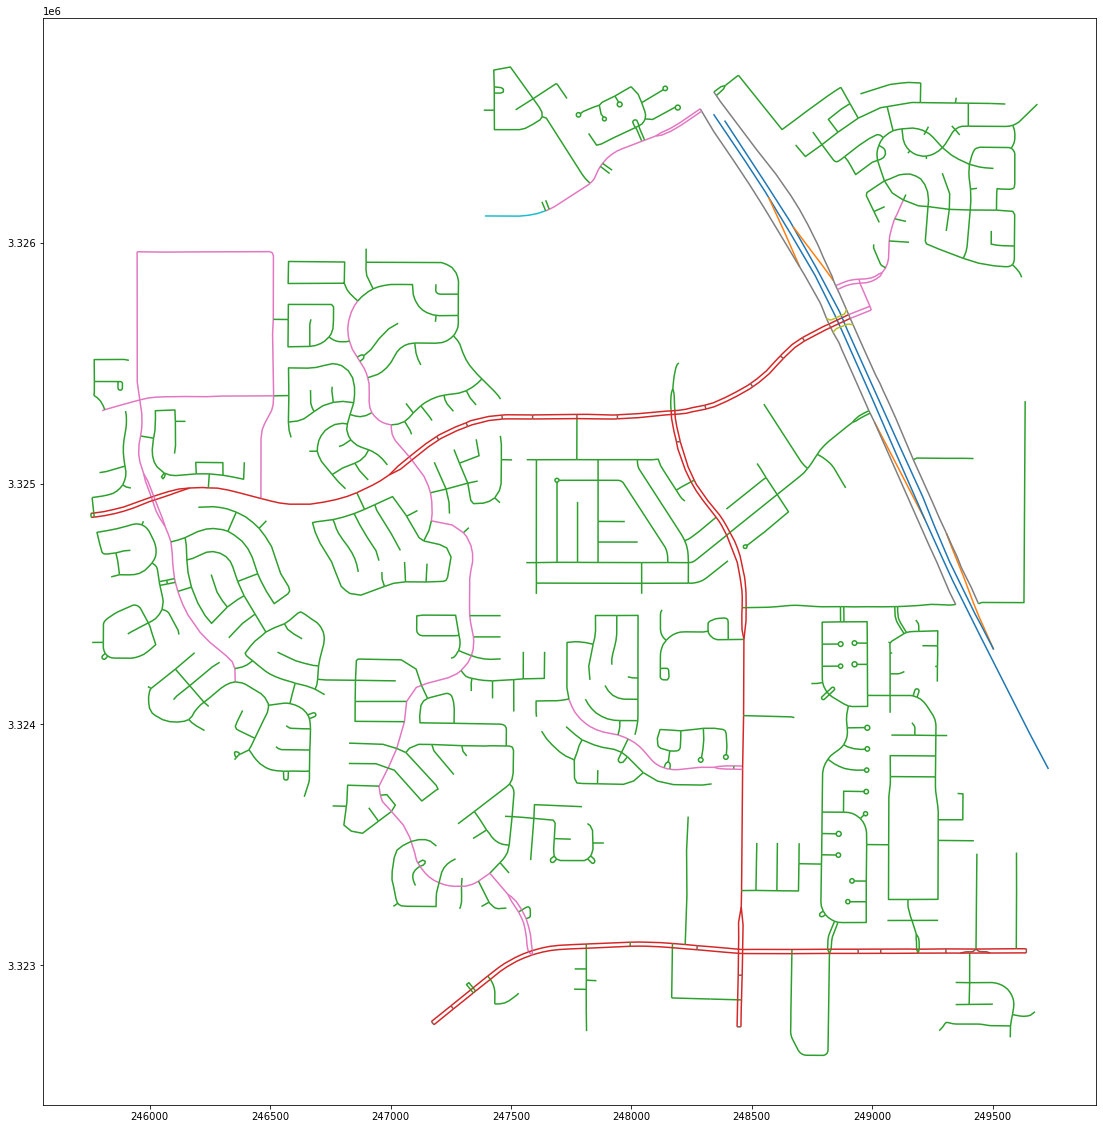

In [23]:
gdf.plot(gdf.highway.astype(str), figsize=(20, 20))

## Consolidate nodes

In [4]:
%%time
cons_nodes, midpoints = consolidate_nodes(gdf, 20)

CPU times: user 544 ms, sys: 30.9 ms, total: 575 ms
Wall time: 588 ms


In [6]:
# fix topology (spiders to network)
cons_nodes = topology(cons_nodes)

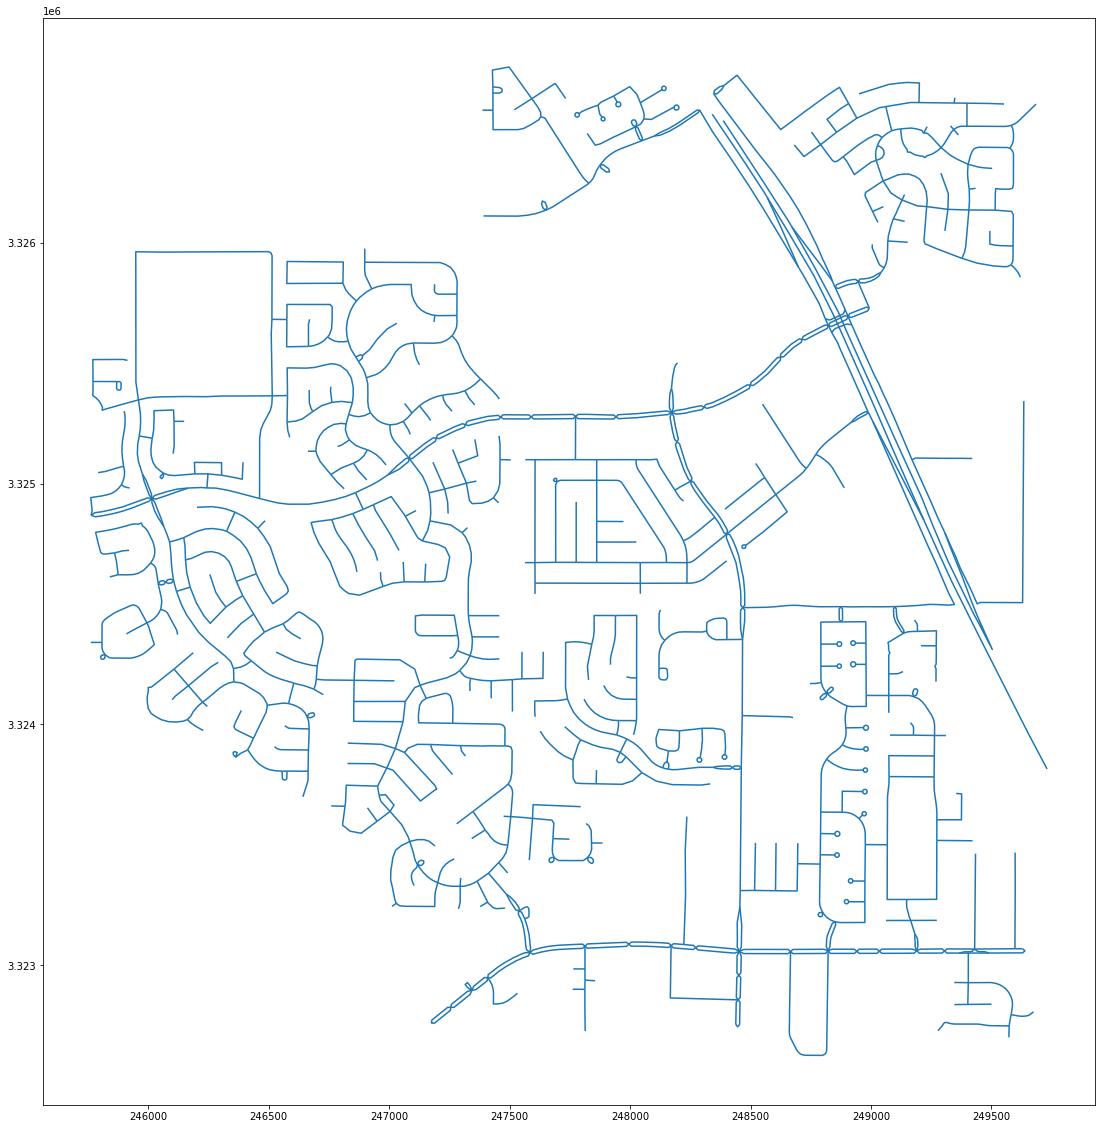

In [7]:
ax=cons_nodes.plot(figsize=(20, 20))
# midpoints.plot(ax=ax, color='r')

## Consolidate edges

### Playground

In [8]:
polygonized = polygonize(cons_nodes.geometry.unary_union)
geoms = [g for g in polygonized]
poly = gpd.GeoDataFrame(geometry=geoms, crs=cons_nodes.crs)

In [34]:
gdf[['geometry']].to_file('temp.gpkg', driver='GPKG', layer='orig_undir')

<AxesSubplot:>

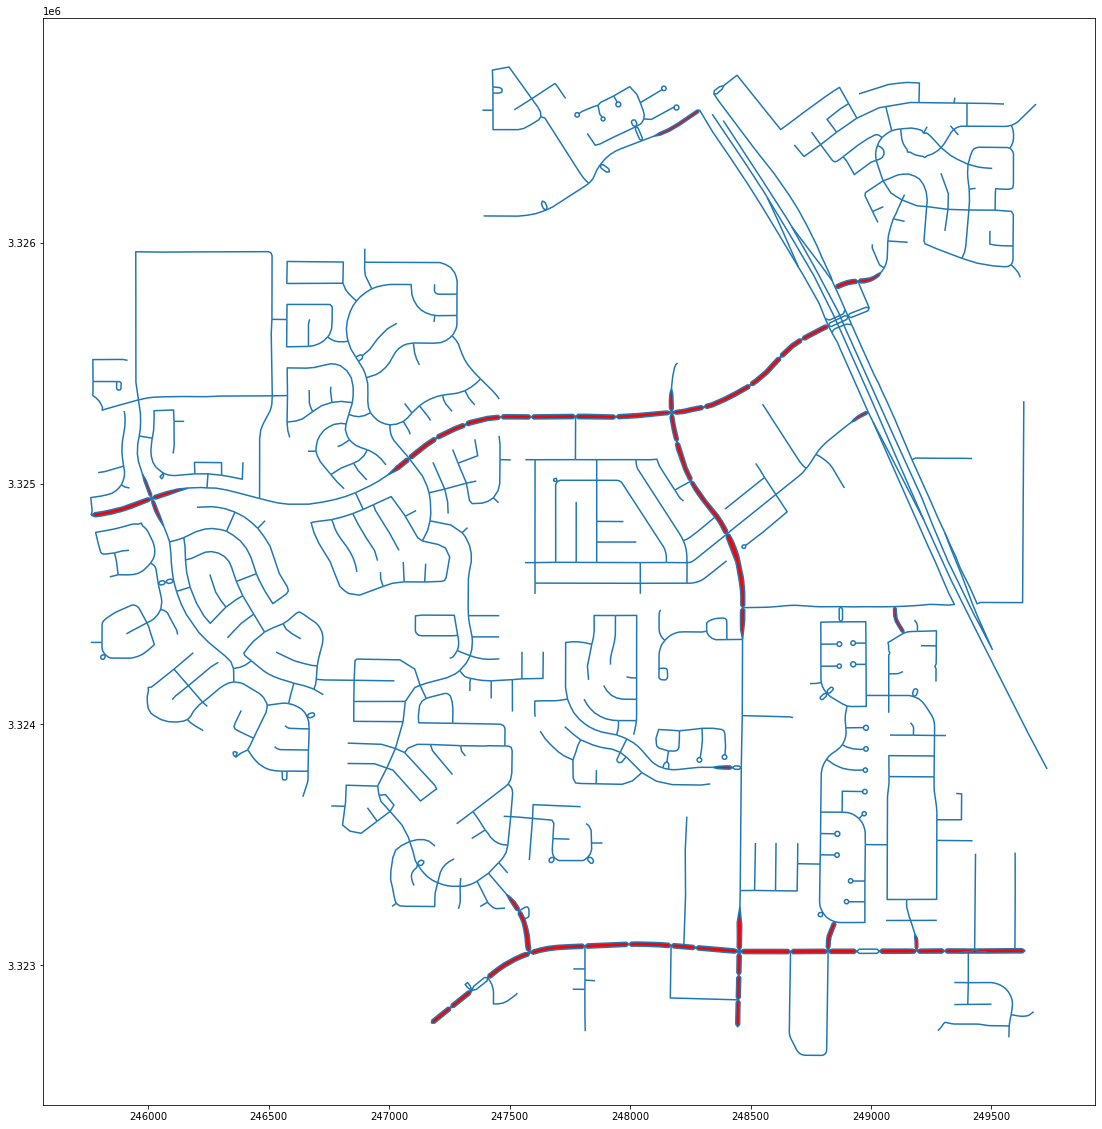

In [10]:
ax = cons_nodes.plot(figsize=(20, 20))
poly[filter_comp(poly, 8000, .2)].plot(ax=ax, color='r')

In [11]:
first = consolidate(cons_nodes, filter_func=filter_comp, max_size=8000)

<AxesSubplot:>

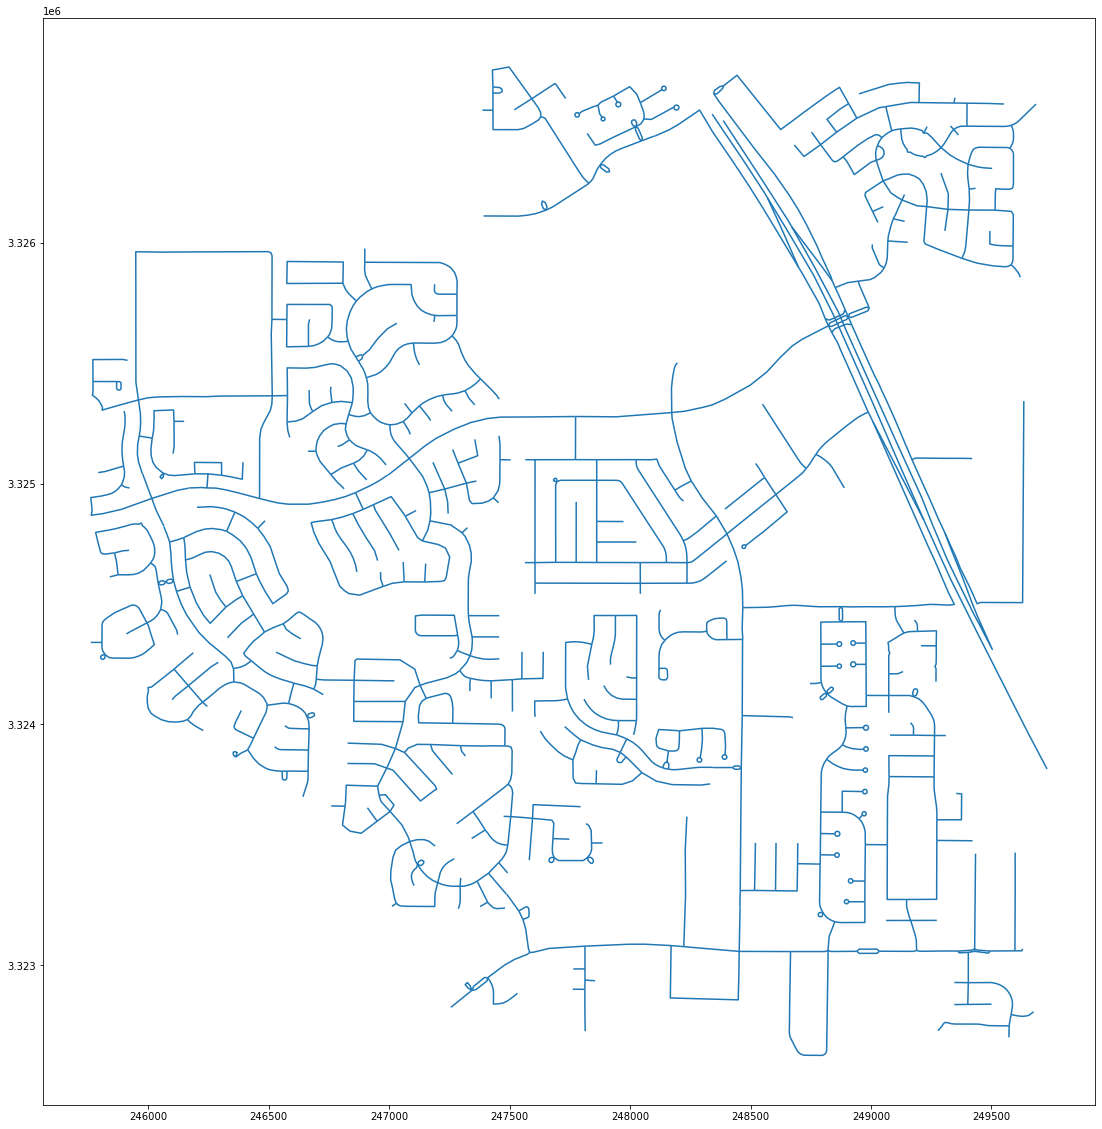

In [12]:
first.plot(figsize=(20, 20))

In [15]:
def filter_small(gdf, network_, max_size=1000):
    """
    Identify small polygons enclosed by multiple geometries (keeps roundabout at the end of the cul-de-sac)
    """
    small = gdf[gdf.area < max_size]
    inp, res = pygeos.STRtree(small.geometry.values.data).query_bulk(network_.geometry.values.data, predicate='covered_by')
    unique, counts = np.unique(res, return_counts=True)
    return gdf.index.isin(small.iloc[unique[counts>1]].index)

<AxesSubplot:>

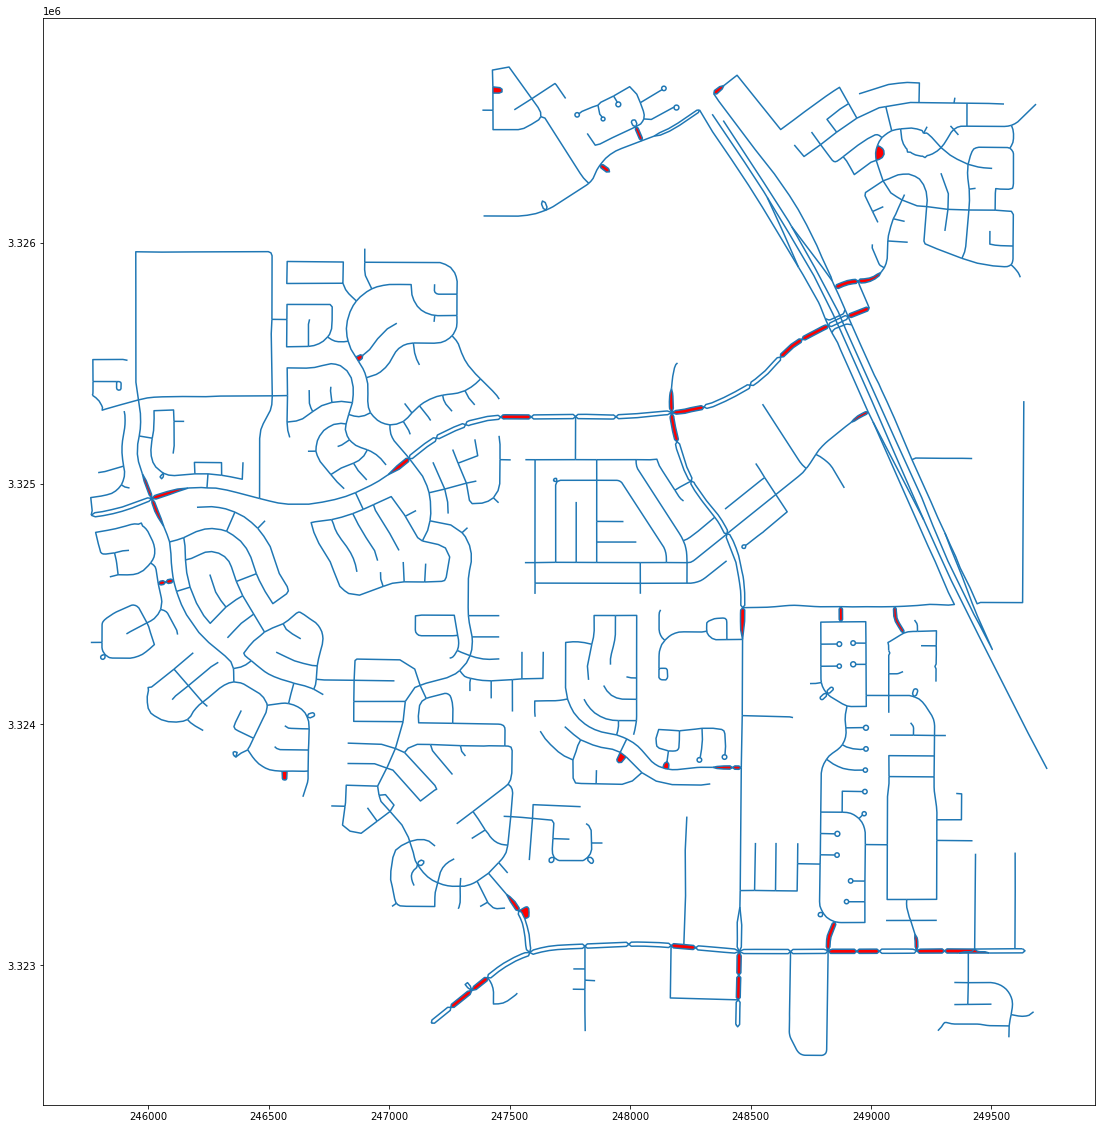

In [19]:
ax=cons_nodes.plot(figsize=(20, 20))
poly[filter_small(poly, cons_nodes, 2000)].plot(ax=ax, color='r')

In [20]:
second = consolidate(first, filter_func=filter_small, network_=first, max_size=2000)

<AxesSubplot:>

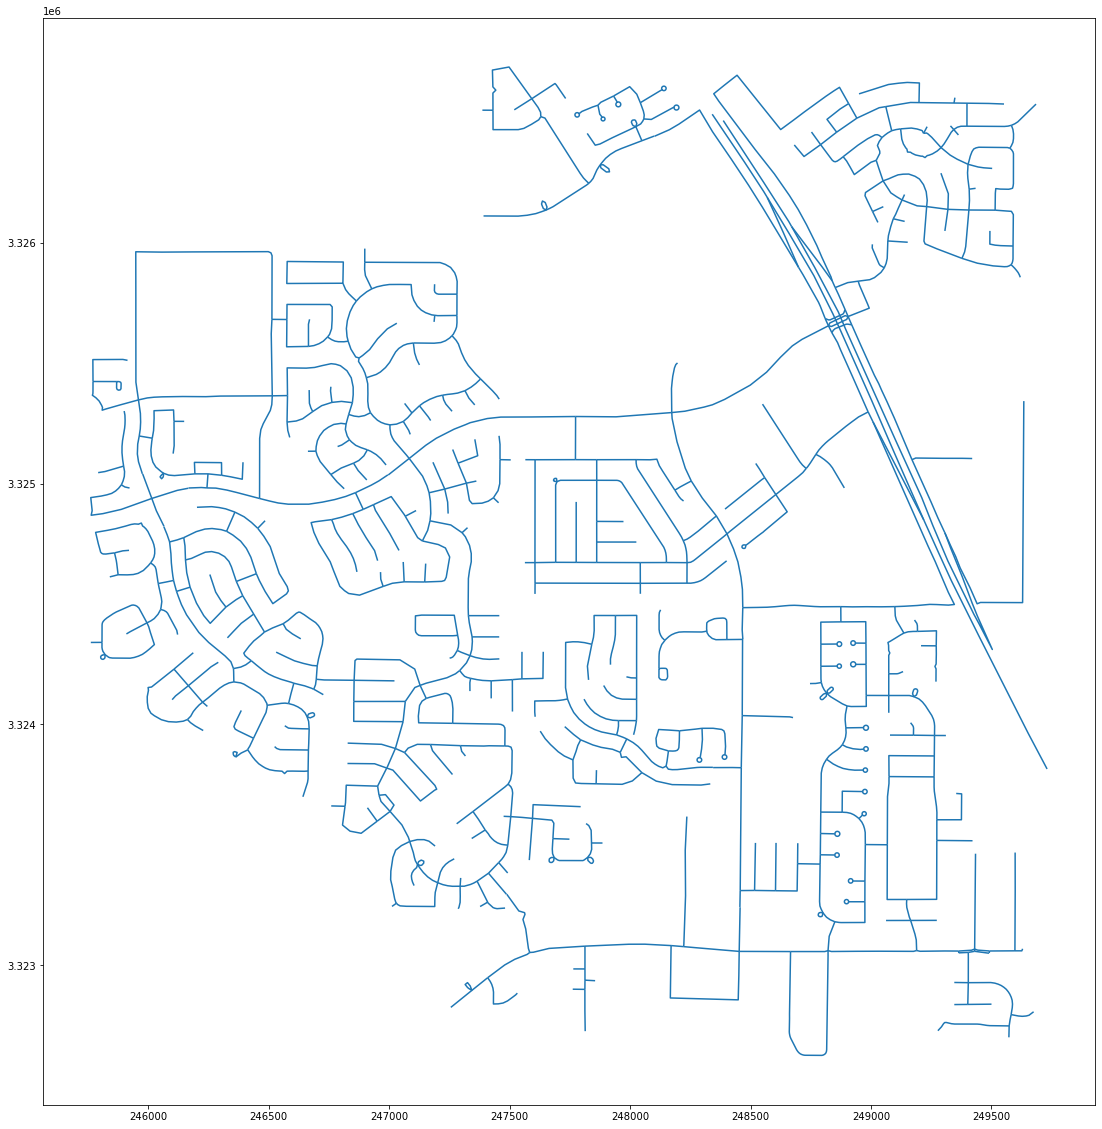

In [21]:
second.plot(figsize=(20, 20))

<AxesSubplot:>

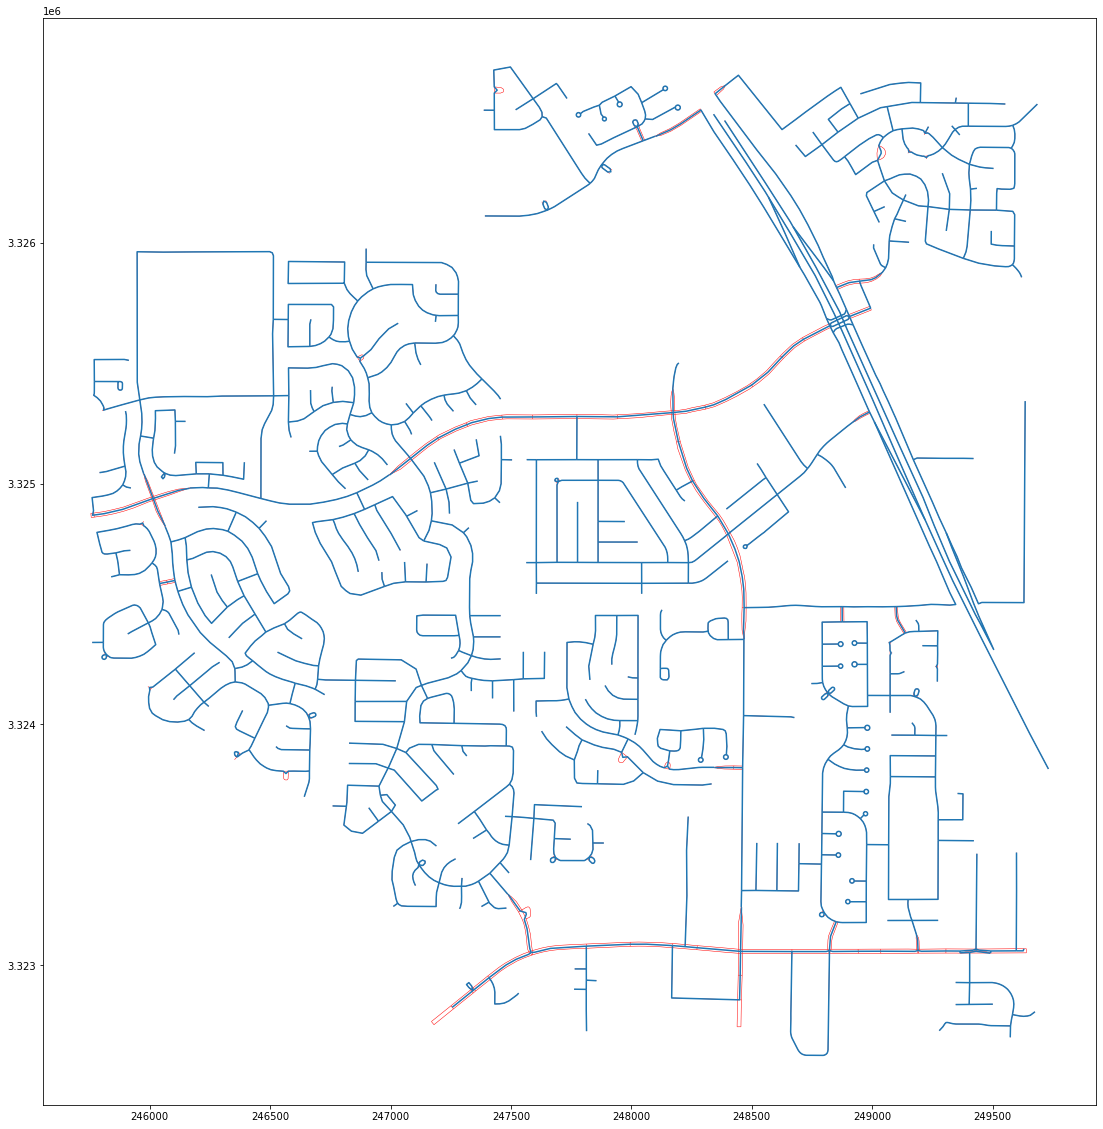

In [22]:
ax = gdf.plot(figsize=(20, 20), color='r', zorder=0, linewidth=.5)
second.plot(ax=ax,zorder=1)

## Larger area

<AxesSubplot:>

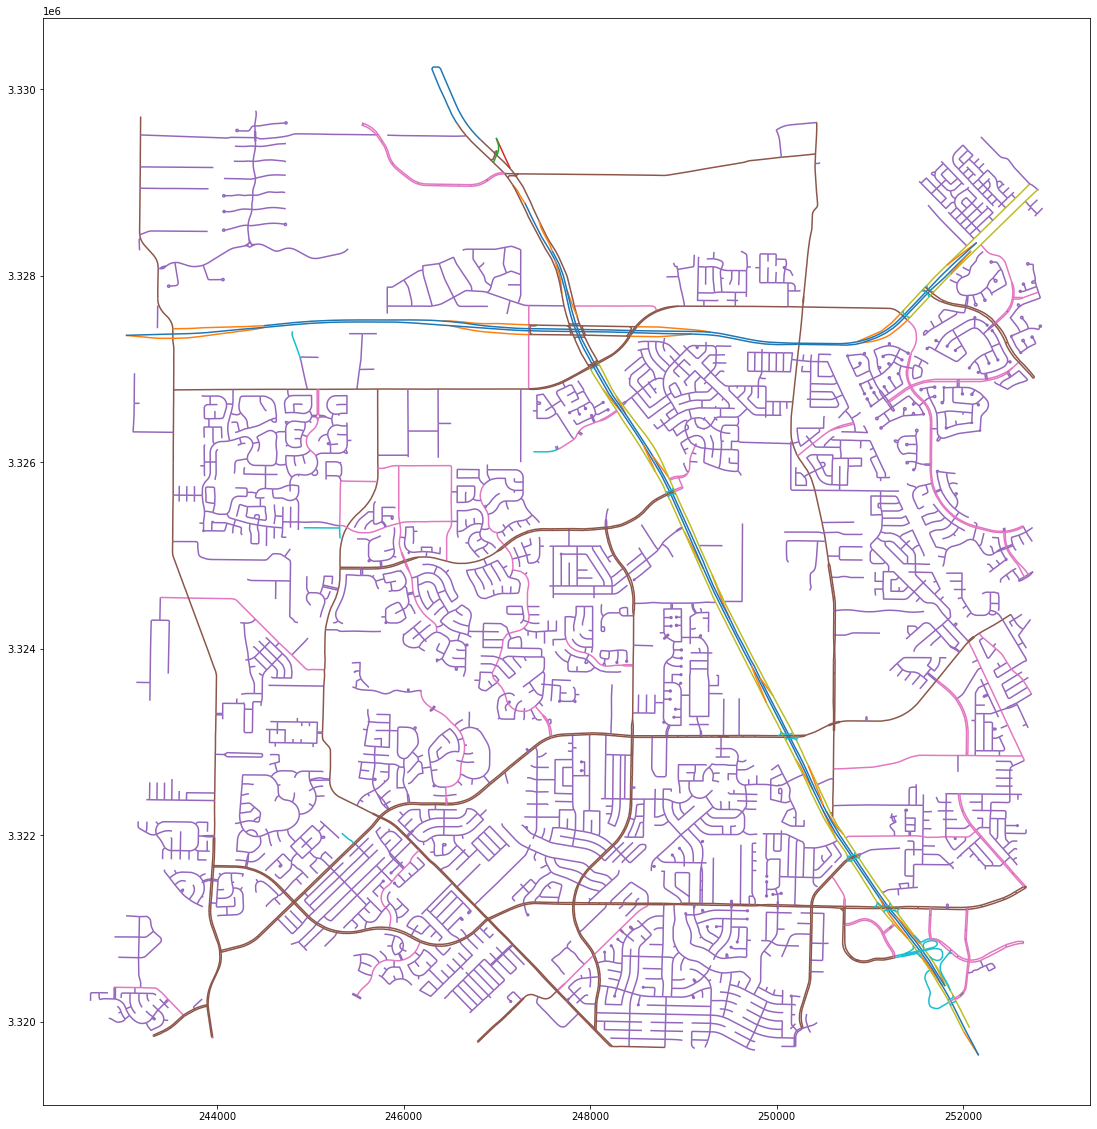

In [27]:
point = (30.027555, -95.615635)
dist = 5000

streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.plot(gdf.highway.astype(str), figsize=(20, 20))

In [28]:
%%time
cons_nodes, midpoints = consolidate_nodes(gdf, 20)

CPU times: user 3.66 s, sys: 18.1 ms, total: 3.68 s
Wall time: 3.7 s


In [29]:
# fix topology (spiders to network)
%time cons_nodes = topology(cons_nodes)

CPU times: user 731 ms, sys: 11 ms, total: 742 ms
Wall time: 748 ms


In [31]:
%time first = consolidate(cons_nodes, filter_func=filter_comp, max_size=8000)
%time second = consolidate(first, filter_func=filter_small, network_=first, max_size=2000)

CPU times: user 4.14 s, sys: 13 ms, total: 4.15 s
Wall time: 4.16 s
CPU times: user 976 ms, sys: 530 µs, total: 977 ms
Wall time: 976 ms


<AxesSubplot:>

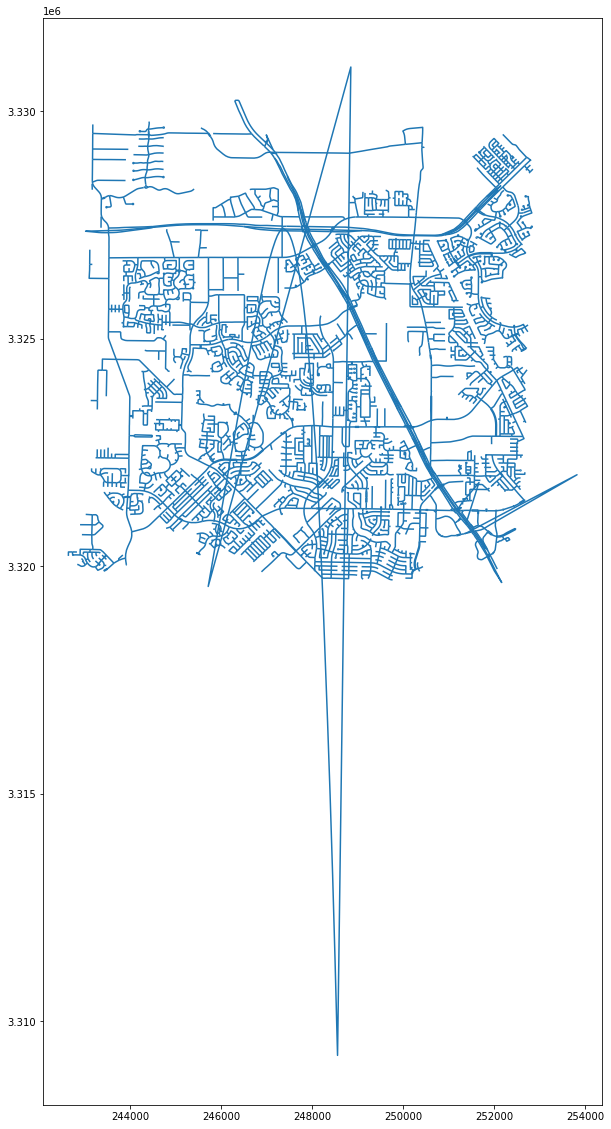

In [33]:
first.plot(figsize=(20, 20))

In [35]:
gdf['highway'] = gdf['highway'].astype(str)
gdf[['geometry', 'highway']].to_file('temp.gpkg', driver='GPKG', layer='orig_undir')